In [1]:
#Import necessary libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
#Shuffles the whole data
def shuffle_array(arr):
    np.random.seed(1337)
    l = len(arr)
    for i in range(0,l):
        index = np.random.randint(0, l)
        arr[i] = arr[index]
        
#Normalization by using numpy's max and min functions
#Returns records with normalized values
def min_max_normalization(X_data):
    max_element_column = X_data.max(axis = 0) #Finding maximum elements for each column
    min_element_column = X_data.min(axis = 0) #Finding minimum elements for each column
    return (X_data - min_element_column)/(max_element_column - min_element_column)

#Returns class names within a dictionary
#Return type: number of unique classes, {'class_name': index}
def get_classes_from_data(arr, classIndex):
    unique = np.unique(arr[:, classIndex])
    classes_dict = {}
    for i in range(len(unique)):
        classes_dict[unique[i]] = i
    return len(unique), classes_dict

#Splits train and test data
#k_fold parameter is there for k_fold cross validation, set default = -1 showing that it is not active
#percentage is there for percentage of the test data over whole data, set default = -1 showing that it is not active
#Return type: X_train, y_train, X_test, y_test
def split_train_test(arr, classIndex, k_fold = -1, percentage = -1, index = 0):
    if (k_fold != -1): test_size = int(len(arr) / k_fold)
    else: test_size = int(len(arr) / 100 * percentage)
    test_array = arr[test_size * index: test_size * (index + 1)]
    train_array = np.delete(arr, slice(test_size * index, test_size * (index + 1)), 0)
    X_train = train_array[:, 0:classIndex]
    y_train = train_array[:, [classIndex]]
    X_test = test_array[:, 0:classIndex]
    y_test = test_array[:, [classIndex]]
    return X_train, y_train, X_test, y_test

#Returns euclidean distance between two records and class type within a tuple
def calculate_euclidean_distance(X_test_instance, X_train_instance, y_train_instance):
    distance = np.sqrt(np.sum((X_test_instance - X_train_instance)**2))
    theClass = y_train_instance[0]
    return [distance, theClass]

#Returns closest points to the specified test instance from train data set
def find_closest_points(X_test_instance, X_train, y_train):
    distances = []
    for i in range(len(X_train)):
        distances.append(
            calculate_euclidean_distance(
                X_test_instance, X_train[i], y_train[i]))
    distances.sort()
    return distances

#distance_pairs: sorted distance pairs
#k: k closest points to the specific test sample
#weighted: if yes weighted, else not weighted classification
#Returns class
def classify(X_test_instance, X_train, y_train, k, weighted):
    distance_pairs = find_closest_points(X_test_instance, X_train, y_train)[:k]
    weighted, un_weighted = dict(), dict()
    
    for pair in distance_pairs:
        w = 1 / (pair[0] + 0.0001)
        
        if (un_weighted.get(pair[1]) != None):
            un_weighted[pair[1]] += 1
        else:
            un_weighted[pair[1]] = 1
        if (weighted.get(pair[1]) != None):
            weighted[pair[1]] += w
        else:
            weighted[pair[1]] = w
    
    sorted_weighted = sorted(weighted.items(), key=lambda x:x[1])
    sorted_unweighted = sorted(un_weighted.items(), key=lambda x:x[1])
    
    if (weighted == True): return sorted_weighted[-1][0]
    else: return sorted_unweighted[-1][0]
    
def plot(conf_matrix, classes):
    df_cm = pd.DataFrame(conf_matrix, index = [i for i in classes], columns = [i for i in classes])
    plt.figure(figsize = (7,7))
    ax = sn.heatmap(df_cm, annot=True, fmt = "d", cmap="YlGnBu", cbar_kws={'label': 'Scale'})
    ax.set(ylabel="Predicted Label", xlabel="Actual Label")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title("Confusion Matrix")
    
class kNN:
    
    def __init__(self, X_train, y_train, X_test, y_test, k, classes, weighted, normalized):
        
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.k = k
        self.classes = classes
        self.weighted = weighted              
        self.confusionMatrix = np.zeros(shape=(len(classes),len(classes)), dtype=int)
        self.normalized = normalized
        
        #normalize the array
        if (normalized):
            self.X_train = min_max_normalization(self.X_train)
            self.X_test = min_max_normalization(self.X_test)
        
        #classification part
        for i in range(len(self.X_test)):
            predicted_class = classify(self.X_test[i], self.X_train, self.y_train, self.k, self.weighted)
            actual_class = self.y_test[i][0]
            self.confusionMatrix[classes[predicted_class],classes[actual_class]] += 1
            
    def get_confusionMatrix(self):
        return self.confusionMatrix
    
    def get_accuracy(self):
        return np.trace(self.confusionMatrix) / np.sum(self.confusionMatrix) * 100
    
    def plot_confMatrix(self):
        plot(self.confusionMatrix, self.classes)
        
    def print_accuracy(self):
        print("Accuracy: {:.2f}%".format(self.get_accuracy()))

In [3]:
classCol = 60 #Index of the column will be used by classifying
percentageVal = 30 #Percentage of test data out of all data
k_val = 9 #K value
index, k_fold = 0, 5 #K-fold parameters

In [4]:
#Array
df = pd.read_csv('subset_16P.csv')
#Dropping ID column
df.drop(columns=df.columns[0], axis=1, inplace=True)
arr = df.to_numpy()
shuffle_array(arr)

In [5]:
len_classes, classes = get_classes_from_data(arr, classCol)
X_train, y_train, X_test, y_test = split_train_test(arr, classCol, percentage = percentageVal)

In [6]:
#kNN class objects
knn_notW = kNN(X_train, y_train, X_test, y_test, k_val, classes, False, False) #Not normalized, Not weighted
knn_W = kNN(X_train, y_train, X_test, y_test, k_val, classes, True, False) #Not normalized, Weighted
knn_norm_notW = kNN(X_train, y_train, X_test, y_test, k_val, classes, False, True) #Normalized, Not weighted
knn_norm_W = kNN(X_train, y_train, X_test, y_test, k_val, classes, True, True) #Normalized, Weighted

Accuracy: 97.93%


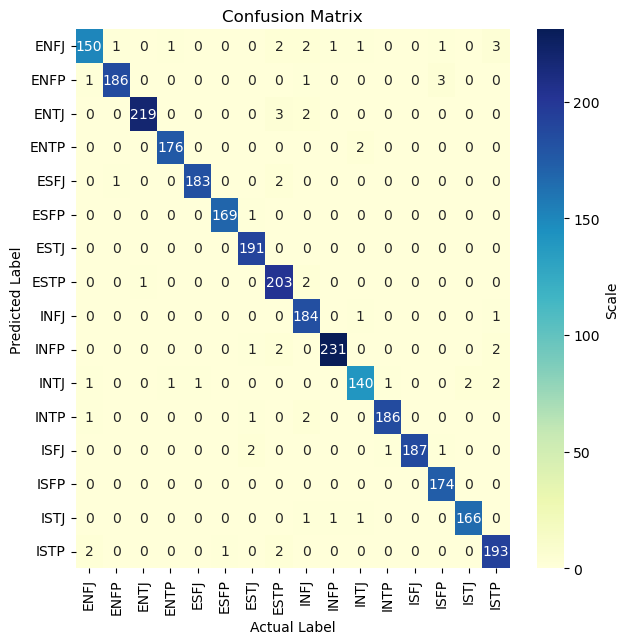

In [7]:
knn_notW.plot_confMatrix()
knn_notW.print_accuracy()

Accuracy: 97.93%


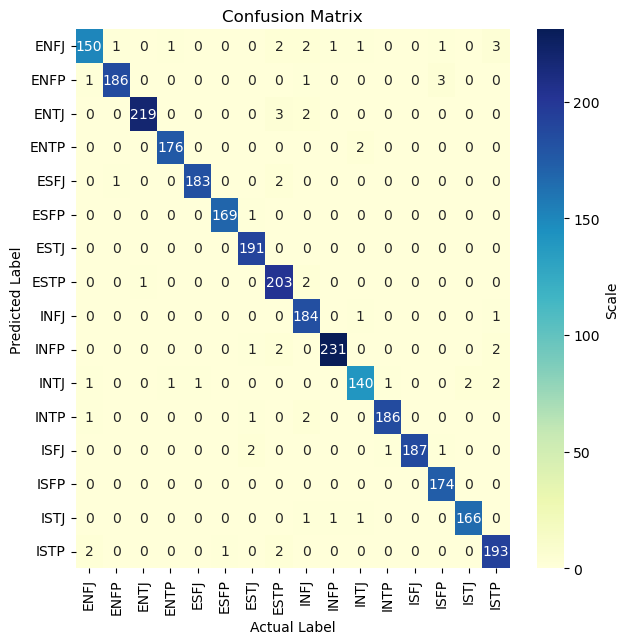

In [8]:
knn_W.plot_confMatrix()
knn_W.print_accuracy()

Accuracy: 97.00%


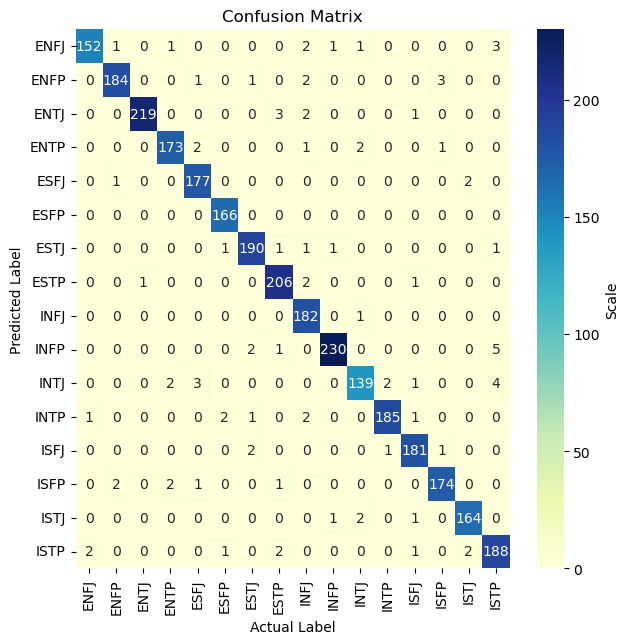

In [9]:
knn_norm_notW.plot_confMatrix()
knn_norm_notW.print_accuracy()

Accuracy: 97.00%


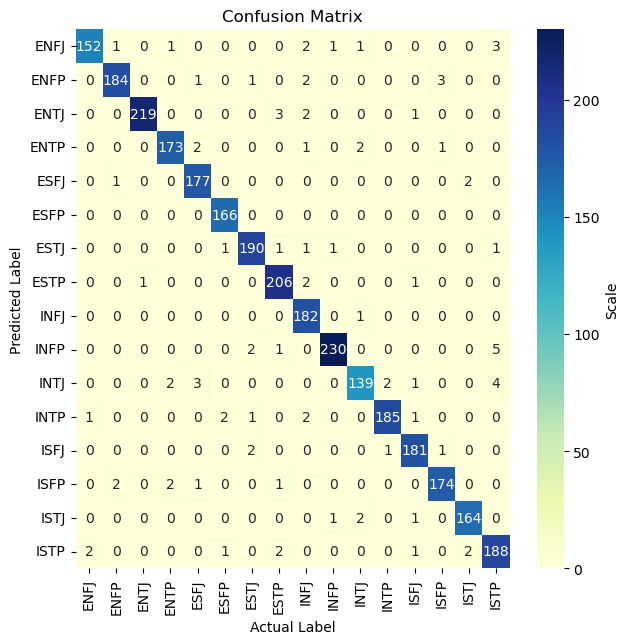

In [10]:
knn_norm_W.plot_confMatrix()
knn_norm_W.print_accuracy()

In [11]:
print("k-NN algorithm tuning k value with the dataset.")
for k in [1, 3, 5, 7, 9]:
    knn_obj = kNN(X_train, y_train, X_test, y_test, k, classes, False, False) #Not Normalized, Not weighted
    print("k-NN algorithm current k value: {}".format(k))
    knn_obj.print_accuracy()

k-NN algorithm tuning k value with the dataset.
k-NN algorithm current k value: 1
Accuracy: 99.00%
k-NN algorithm current k value: 3
Accuracy: 98.57%
k-NN algorithm current k value: 5
Accuracy: 98.03%
k-NN algorithm current k value: 7
Accuracy: 98.00%
k-NN algorithm current k value: 9
Accuracy: 97.93%


In [12]:
print("k-NN algorithm k-fold cross validation.")
for index in range(k_fold):
    X_train, y_train, X_test, y_test = split_train_test(arr, classCol, k_fold = 5, index = index)
    knn_obj = kNN(X_train, y_train, X_test, y_test, k, classes, False, False) #Not Normalized, Not weighted
    print("k-NN algorithm fold number: {}".format(index+1))
    knn_obj.print_accuracy()

k-NN algorithm k-fold cross validation.
k-NN algorithm fold number: 1
Accuracy: 97.95%
k-NN algorithm fold number: 2
Accuracy: 98.15%
k-NN algorithm fold number: 3
Accuracy: 98.60%
k-NN algorithm fold number: 4
Accuracy: 98.40%
k-NN algorithm fold number: 5
Accuracy: 98.65%
